In [1]:
#librairy
#import the droplet file and load them in a dataframe
import pandas as pd
import numpy as np
import os
from os import listdir
from os.path import isfile, join, isdir
import matplotlib.pyplot as plt
import scipy.optimize
import scipy.interpolate as si


In [118]:
#main analysis with derivative
def plotHistAll(gRate,label,title,path,low,up,nameFolder):
    choice=['blue','green','red','cyan','magenta','yellow','black']
    colors=choice[0:len(label)]    
    i=-1
    
    for l in label:
        i+=1
        xxx=gRate[l][np.logical_not(np.isnan(gRate[l]))]
        xx=xxx[np.logical_not(np.isinf(xxx))]
        x=xx[np.logical_not(xx==-1)]

        #x=gRate[l]
        print(l)
        print(len(x))
        hist, bins = np.histogram(x, bins='fd')
        #hist, bins = np.histogram(x, bins=100, range=(0,2))
        width = 0.7 * (bins[1] - bins[0])
        center = (bins[:-1] + bins[1:]) / 2

        #plt.plot(center, hist,color=colors[i],linewidth=2, label=l+' Md={:.4f}'.format(np.median(x)) +' std={:.4f}'.format(np.std(x))+' N={:.4f}'.format(np.mean(x)))
        plt.plot(center, hist/len(x),color=colors[i],linewidth=2, label=l+' Md={:.4f}'.format(np.median(x)) +' std={:.4f}'.format(np.std(x))+' N={:d}'.format(len(x)))
        plt.scatter(center, hist/len(x),color=colors[i])

    plt.xlim([low, up])    
    plt.legend(loc='best')
    plt.ylim([0,1])
    plt.title(nameFolder+'\n'+title)
    fig1 = plt.gcf()
    fig1.savefig(path+nameFolder+title)
    plt.show()
    

In [125]:
#main analysis with derivative NO split B/F
#seuil sur le temps de la detection du max gRate
#seuil sur le plus petit gRate possible 0.4
#seuil sur le chi2 du gRate 10 (valeur de 1 pour le chi/10 ici)
from pandas import DataFrame as pddf
from pandas import Series as pds
import bisect
thplot=0 #plot des droites en phase exponentiel
incCarte=5e-3 #incertitude de lamesure par la carte hardware
def plotDerivativeSeparate(df, dropMap, label, channel,low=0, high=5, namePath='', nbpt=2, seuilGrate=0.9, display=0,minGrate=0.5 ,maxLag=27):
    choice=['blue','green','red','cyan','magenta','yellow','black']

    colors=choice[0:len(label)];
    gRate = pddf()
    yld = pddf()
    lag = pddf()
    gRateStd = pddf()
    incRate = pddf()
    chi2red = pddf()
    derData = pddf()
    gRateTime=pddf()
    nbDrop=pddf()
    
    pathgrowth=path+'/nbpt'+str(nbpt)+'/'
    if not os.path.exists(pathgrowth):
        os.makedirs(pathgrowth)
    
    for j,tmp in enumerate(label):
        y=[]
        x=[]
        d=[]
        m=0

        gRatetmp = []
        lagtmp = []
        yldtmp = []
        incRatetmp=[]
        chi2tmp=[]
        gRateTimetmp=[]
        nbDroptmp=[]
        
        derTmp = dict()
        kk=0
        kkk=0
        for j,content in enumerate(dropMap[:,1]):

            if content==tmp:    
                if channel=='mCherry':
                    p=df[j]
                    y=np.array(np.log(p.fluo_2_area*p.speed/p.size))
                    x=np.array(p.time/3600) 
                    ystd=np.array(np.divide(p.fluo_2_std+incCarte/2,p.fluo_2_median))
                if channel=='GFP':
                    p=df[j]
                    y=np.array(np.log(p.fluo_3_area*p.speed),dtype=np.float64)
                    x=np.array(p.time/3600,dtype=np.float64)
                    ystd=np.array(np.divide(p.fluo_3_std+incCarte/2,p.fluo_3_median))

                if channel=='PVD':
                    p=df[j]
                    y=np.array(np.log(p.fluo_1_area*p.speed))
                    x=np.array(p.time/3600,dtype=np.float64)
                    ystd=np.array(np.divide(p.fluo_1_std+incCarte/2,p.fluo_1_median))

                der=[]
                xM=[]
                yM=[]
                errM=[]
                xder=[]
                derErr=[]
                chi_squared=[]

                allXF=list()
                allDerivF=list()
                allXB=list()
                allDerivB=list()


                if display>=1:
                    fig, ax1 = plt.subplots()#s(1,3,sharex=True)

                a2=0.7
                b2=-7

                #fit slots of the growth curves
                for i in range(1,len(x)-nbpt): #no split odd/even runs even if :##split odd/even because even runs have asymetric peak

                    xM=np.array(x[i:i+nbpt])
                    yM=np.array(y[i:i+nbpt])
                    errM=np.array(ystd[i:i+nbpt])

                    # fit explicitly taking uncertainty into account
                    g = lambda x, a, b: a*x + b  # function to fit
                    # fit with initial guess for parameters [1, 1]
                    try :
                        if len(errM)==len(xM) and len(xM)==len(yM) and len(xM)>=nbpt and np.min(yM)>np.log(incCarte): 
                            pars, corr = scipy.optimize.curve_fit(g, xM, yM, [.7, b2], errM)
                            a2, b2 = pars
                            perr = np.sqrt(np.diag(corr))

                            chi2=np.sum(np.divide((g(xM,a2,b2) - yM) ** 2,errM**2))/(len(xM)-2)
                            if chi2<30:
                                chi_squared.append(chi2/10)
                                der.append(a2)
                                derErr.append(perr[0])
                                xder.append(np.mean(xM))


                    except Exception as inst:
                        donothing=0
                        #print(type(inst))     # the exception instance
                        #print(inst.args)      # arguments stored in .args
                        #print(inst)           # __str__ allows args to be printed directly
                        #print('position='+str(i)+ ' drop='+str(j))



                    if display >= 1: #plot the line used to fit

                        if xM[0]>thplot and xM[0]<thplot+20 and chi2<30: #plot in the exp phase
                            ax1.plot(x,g(x,a2,b2))                                

                derTmp[j]=[xder, der] #enregistre la courbe de derivée
                der = np.array(der)
                xder = np.array(xder)
                derErr = np.array(derErr)
                chi_squared = np.array(chi_squared)


                thLag=bisect.bisect(y, y[0]+0.5)
                if thLag<len(x):
                    if  x[thLag]<maxLag :
                        lagtmp = lagtmp + [x[thLag]]
                    else : 
                        lagtmp = lagtmp + [-1]
                else : 
                    lagtmp = lagtmp + [-1]
                    
                    
                try :
                    mx = np.max(der)
                    gRatetmp.append(-1)
                    gRateTimetmp.append(-1)
                    incRatetmp.append(-1)
                    chi2tmp.append(np.mean(chi_squared[der>=seuilGrate*mx]))

                    if xder[mx==der]<seuiTemps :#and np.max(xder)>seuiTemps:
                        gR = np.mean(der[der>=seuilGrate*mx])
                        if  np.mean(chi_squared[der>=seuilGrate*mx])<.2 and gR>minGrate: #le chi est divisé par 10 pour raison d'affichage

                            gRatetmp[-1]=gR
                            incRatetmp[-1]=np.sqrt(np.sum(derErr[der>=seuilGrate*mx]**2))
                            chi2tmp[-1]=np.mean(chi_squared[der>=seuilGrate*mx])
                            gRateTimetmp= gRateTimetmp + [np.mean(xder[der>=seuilGrate*mx])-x[thLag]]
                            nbDroptmp=nbDroptmp +[j]

                    
                                #print('drop='+str(j))
                except Exception as inst:
                    donothing=0
                    #print(type(inst))     # the exception instance
                    #print(inst.args)      # arguments stored in .args
                    #print(inst)           # __str__ allows args to be printed directly
                    #print(xder+der)


                


                mask = ((x >= 30) & (x <= 31))
                if np.mean(y[mask])>1:
                    yldtmp = yldtmp + [np.mean(y[mask])]
                yldtmp = yldtmp + [np.nan]
                

                #plot the growth curve with the fit and the derivative
                if display>=1:
                    ax1.errorbar(x,y,ystd,color='blue',fmt='o')#,marker='o', linestyle='-',color='blue')
                    ax2 = ax1.twinx()
                    ax1.set_ylim([np.log(low), np.log(high)])
                    ax1.set_yticks(range(np.int(np.log(low)), np.int(np.log(high))))
                    ax1.set_ylabel('log(fluo)')
                    ax1.set_xlabel('time (h)')

                    ax2.errorbar(xder,der,derErr,color='green',marker='*', linestyle='-')
                    ax2.plot(xder,chi_squared,color='purple',marker='.', linestyle='-')
                    ax2.set_ylim([0, 1])
                    ax2.set_ylabel('derivative (green), chi2/10 (purple)')

                    plt.title(tmp +' '+ str(nbpt)+' drp'+str(j)+' area')
                    plt.show()
                    fig.savefig(pathgrowth+'drp'+str(j)+'_deriveAll_nbpt'+str(nbpt)+'_'+tmp)
        print(tmp)
        derData[tmp]=pd.Series(derTmp)
        chi2red[tmp] = pd.Series(chi2tmp)
        yld[tmp] = pd.Series(yldtmp)
        lag[tmp] = pd.Series(lagtmp)
        gRate[tmp] = pd.Series(gRatetmp)
        incRate[tmp]=pd.Series(incRatetmp)
        gRateTime[tmp]=pd.Series(gRateTimetmp)
        nbDrop[tmp]=pd.Series(nbDroptmp)
        
    print("seuil temps gRate=" +str(seuiTemps)+"h")
    return [derData, gRate, gRateTime, incRate, chi2red, lag, yld, nbDrop]

In [126]:
#load the data from droplets files

dt = np.dtype([('time','<i4'),]+[(x, '<i2') for x in ['pmt1','pmt2','pmt3']])
seuiTemps=24 #recherche du gRate avant cette seuil
minGrate=0.50
maxLag=20
#rootPath='/Users/maxime/Documents/experiences/milli/MILLIDROP_manip/2018-01-11_dilution_CAA_WT-stock14h33/'
#rootPath='/Users/maxime/Documents/experiences/milli/MILLIDROP_manip/2018-01-17_dilution_CAA_WT-stock14h33-19h-43h/'
#rootPath='/Users/maxime/Documents/experiences/milli/MILLIDROP_manip/2018-01-19_dilution_CAA_WT-stock14h33-19h-43h/'
#rootPath='/Users/maxime/Documents/experiences/milli/MILLIDROP_manip/2018-01-23_dilution_CAA_WT-stock14h33-19h-43h/'
#rootPath='/Users/maxime/Documents/experiences/milli/MILLIDROP_manip/2018-01-27_dilution_CAA_WT-stock24h30-6h30-24h-52h/'
#rootPath='/Users/maxime/Documents/experiences/milli/MILLIDROP_manip/2018-01-29_dilution_CAA_WT-stock24h30-6h30-24h-52h/'
#rootPath='/Users/maxime/Documents/experiences/milli/MILLIDROP_manip/2018-01-31_dilution_CAA_WT-stock24h30-6h30-24h-52h/'
rootPath='/Users/maxime/Documents/experiences/milli/MILLIDROP_manip/2018-04-01_dilution_CAA_WT-stock2_increasePressure/'
folder=[rootPath+'analysis/']

#rootPath='/Users/maxime/Documents/experiences/milli/goodExperiments/'
#rootPath='/Users/maxime/Documents/experiences/milli/experienceDilutionWTstock2/'
#rootPath='/Users/maxime/Documents/experiences/milli/expIncub_4h30-6h30-24h-52h/'
#rootPath='/Users/maxime/Documents/experiences/milli/expIncubation_14h-19h-43h/'

#folder=[join(join(rootPath,o),'analysis/') for o in listdir(rootPath) if o[:3]=='201']

#rootPath='/Users/maxime/Documents/experiences/milli/MILLIDROP_manip/2018-02-09_dilution_CAA_WT-stock2/'
#rootPath='/Users/maxime/Documents/experiences/milli/MILLIDROP_manip/2018-02-17_dilution_CAA_WT-stock2/'
#rootPath='/Users/maxime/Documents/experiences/milli/MILLIDROP_manip/2018-02-19_dilution_CAA_WT-stock2/'
#rootPath='/Users/maxime/Documents/experiences/milli/MILLIDROP_manip/2018-02-21_dilution_CAA_WT-stock2/'
#rootPath='/Users/maxime/Documents/experiences/milli/MILLIDROP_manip/2018-02-27_dilution_CAA_WT-stock24h30-6h30-24h-52h/'
#rootPath='/Users/maxime/Documents/experiences/milli/MILLIDROP_manip/2018-03-01_dilution_CAA_WT-stock24h30-6h30-24h-52h/'
#rootPath='/Users/maxime/Documents/experiences/milli/MILLIDROP_manip/2018-03-05_dilution_CAA_WT-stock24h30-6h30-24h-52h/'
#rootPath='/Users/maxime/Documents/experiences/milli/MILLIDROP_manip/2018-03-08_dilution_CAA_WT-stock24h30-6h30-24h-52h/'
#folder=[rootPath+'analysis/']
#rootPath='/Users/maxime/Documents/experiences/milli/expDilution_5_50_500_3500/'
#folder=[join(join(rootPath,o),'analysis/') for o in listdir(rootPath) if o[:3]=='201']

def loadData(path):
    drpfiles=[path+'droplets/' + f for f in listdir(path + 'droplets/') if isfile(join(path + 'droplets/',f)) and f!='.DS_Store']
    i=0
    df={}
    for file in drpfiles:
        df[i]=pd.read_csv(file)
        i+=1 

        #create the template file in hiccup mode
    tpfile=pd.read_csv(path+'template.csv', header=4)
    tpFileOrd=tpfile.set_index('order')
    label=list(set(tpfile['description']))
    label2=[l for l in label if l!='Empty' and l!='CAA']
    dropMap=[]


    for i in range(0,len(tpFileOrd)-1,2):
        for j in range(tpFileOrd.droplet_number[i]+tpFileOrd.droplet_number[i+1]):
            if j%2==0 :
                dropMap.append([tpFileOrd.well[i], tpFileOrd.description[i]])
            else : 
                dropMap.append([tpFileOrd.well[i+1], tpFileOrd.description[i+1]])

    dropMap=np.array(dropMap)
    
    return [dropMap, df, label2]



start
/Users/maxime/Documents/experiences/milli/MILLIDROP_manip/2018-04-01_dilution_CAA_WT-stock2_increasePressure/analysis/
['SBW25-WT_CAA_3500', 'SBW25-WT_CAA_5', 'SBW25-WT_CAA_50', 'SBW25-WT_CAA_500']
attention area*v


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:57: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/usr/local/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


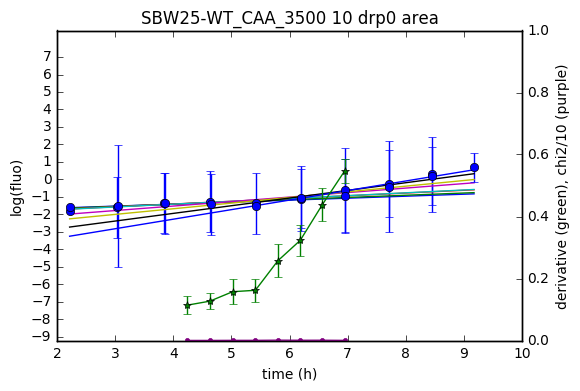

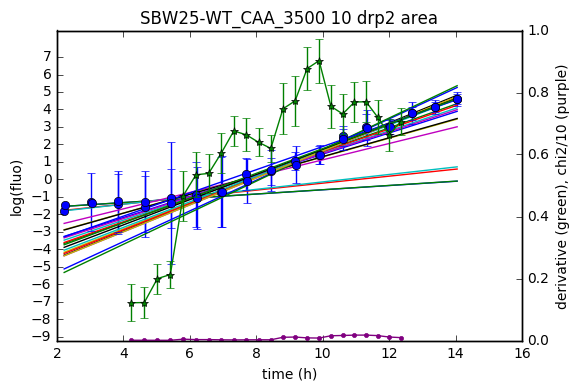

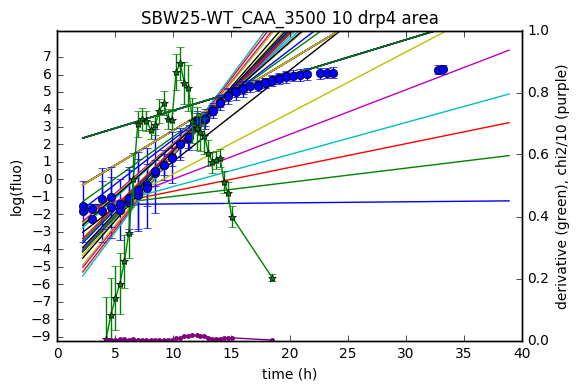

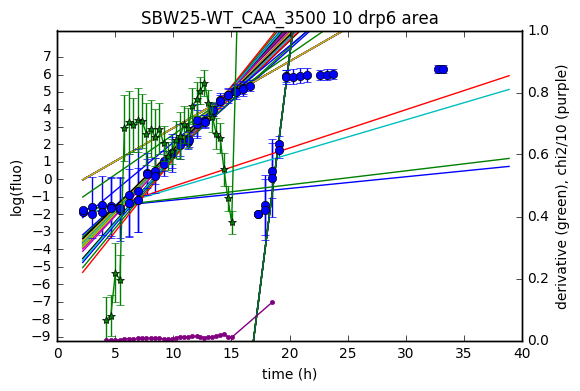

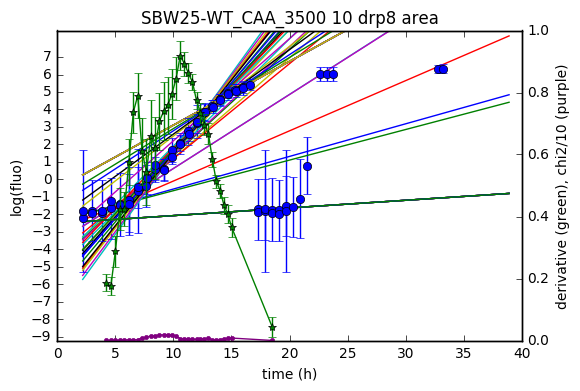

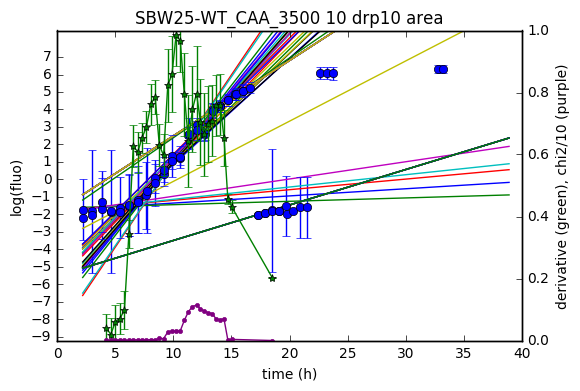

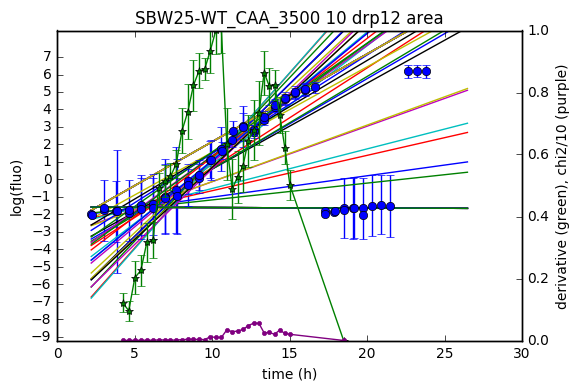

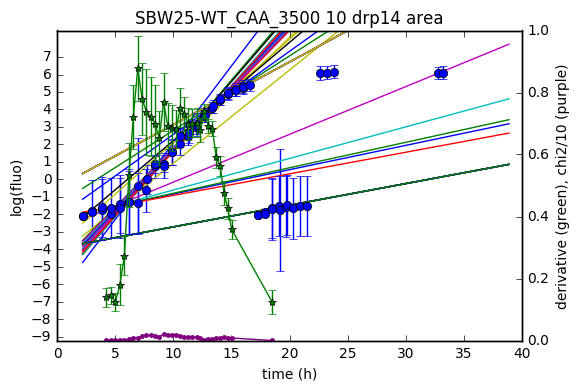

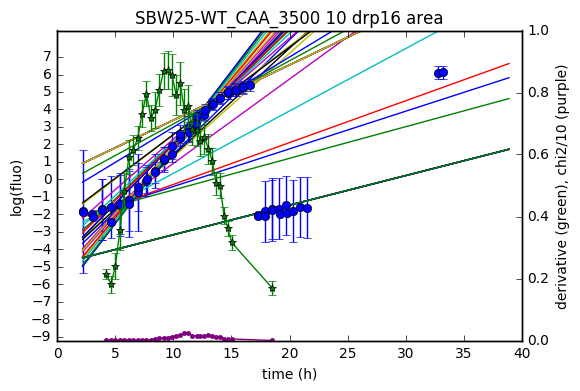

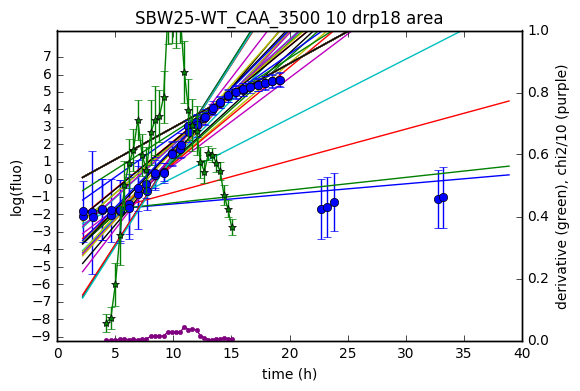

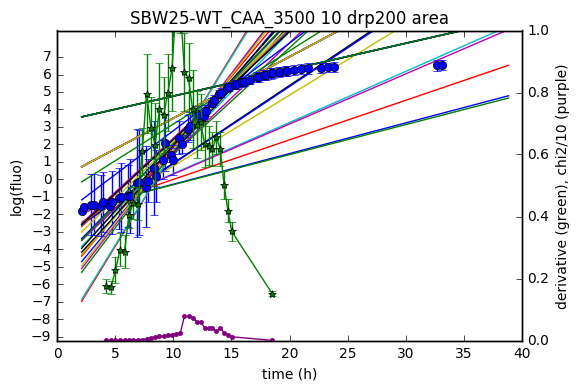

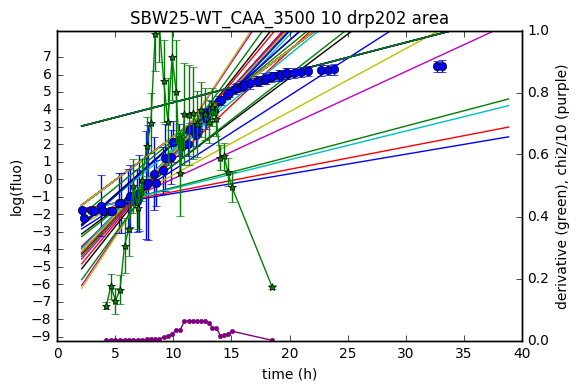

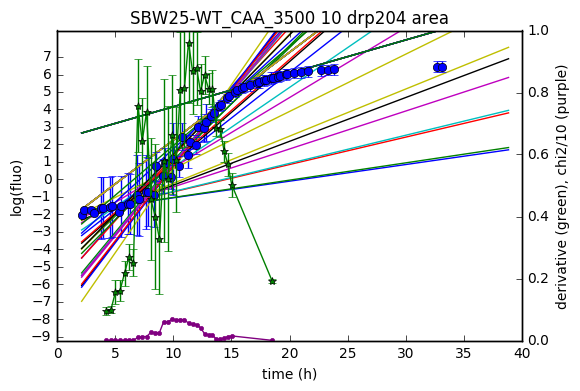

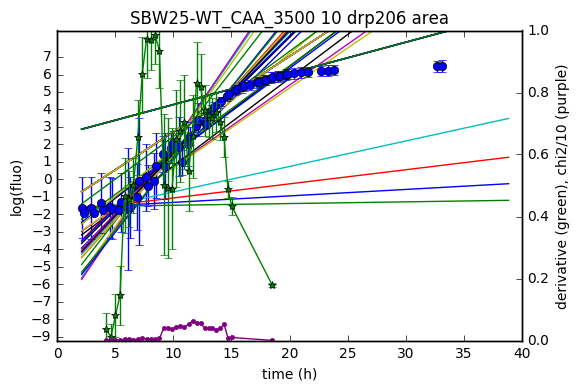

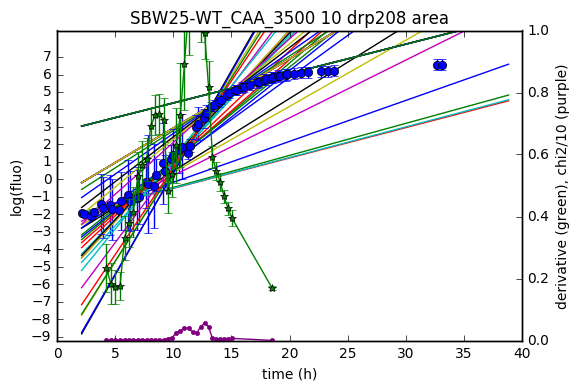

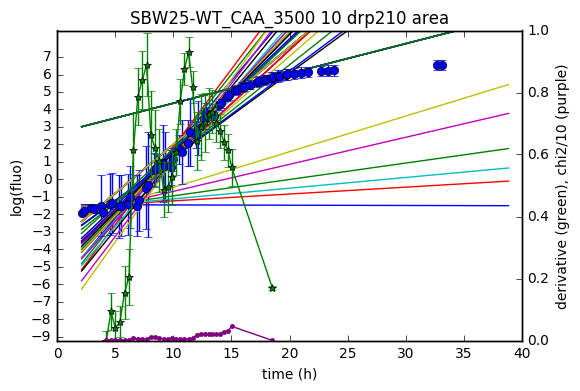

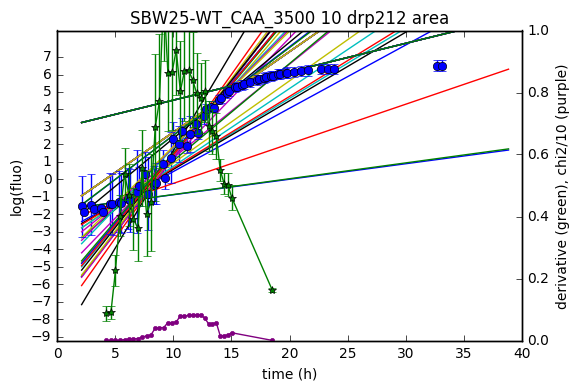

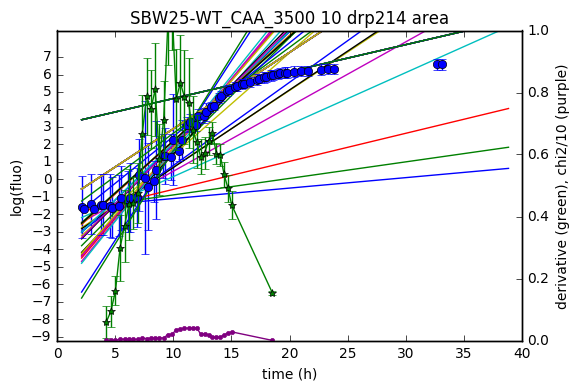

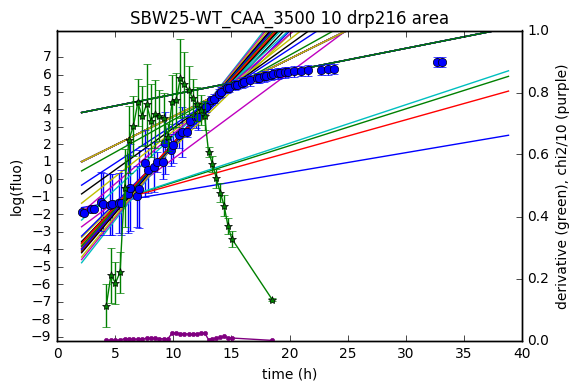

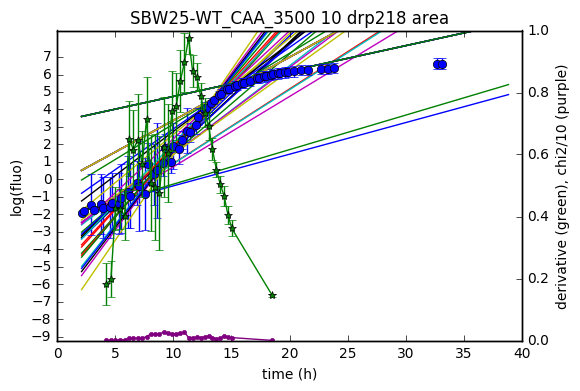

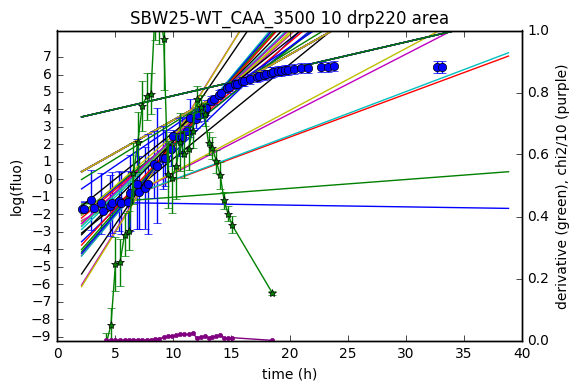

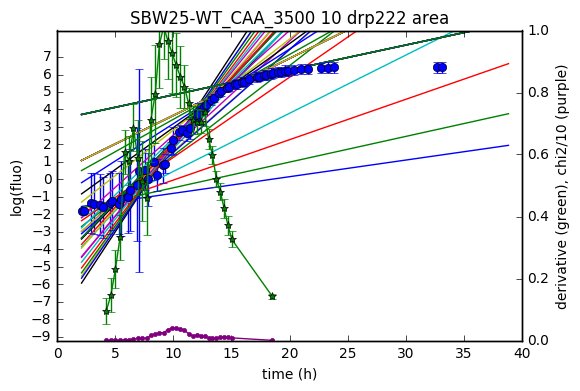

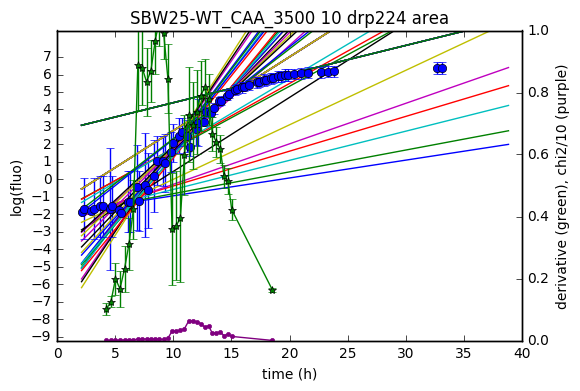

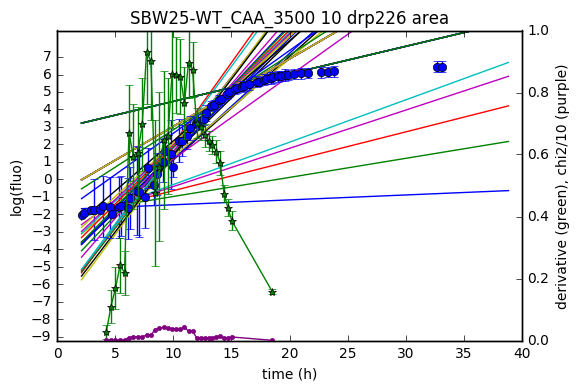

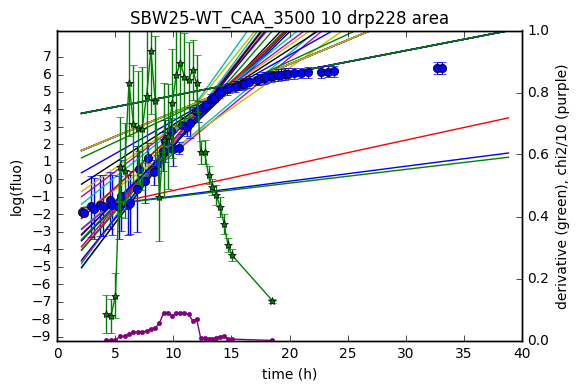

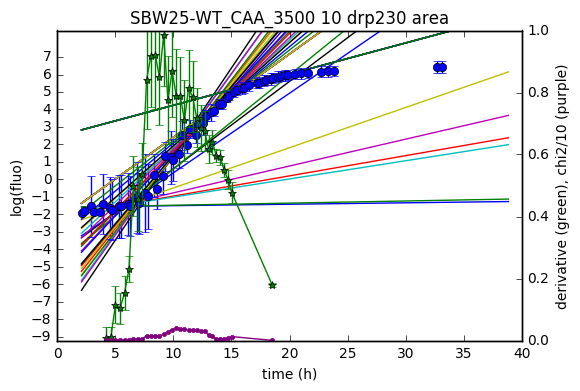

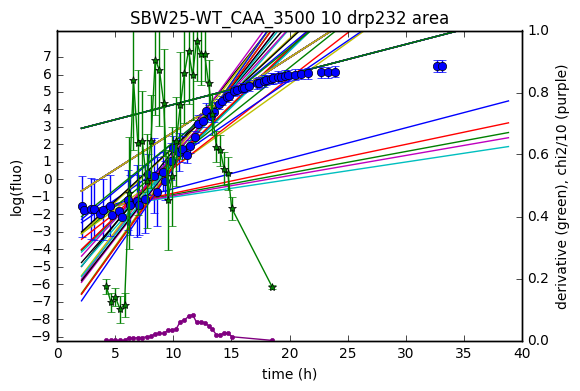

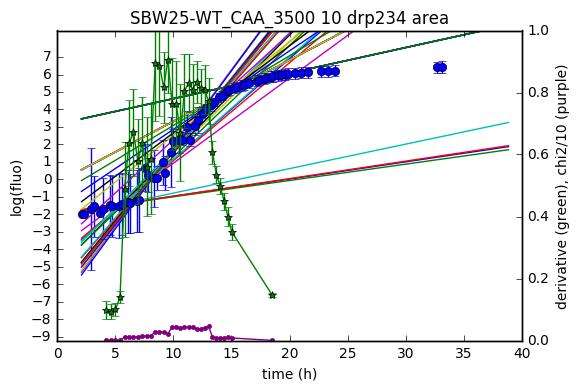

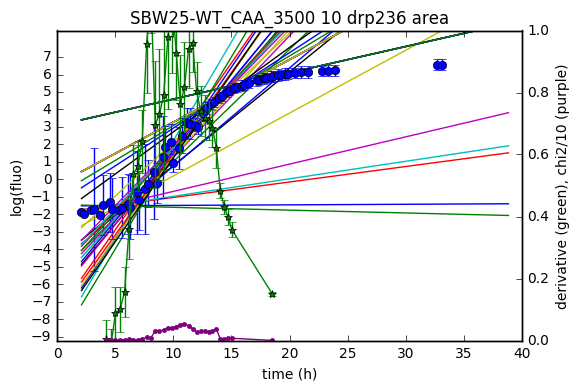

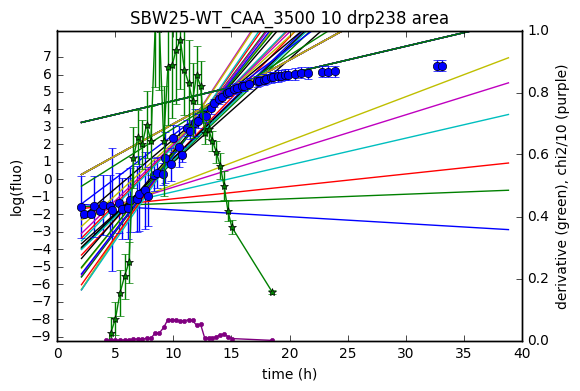

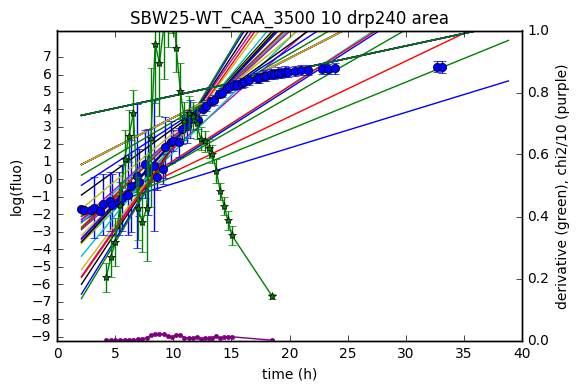

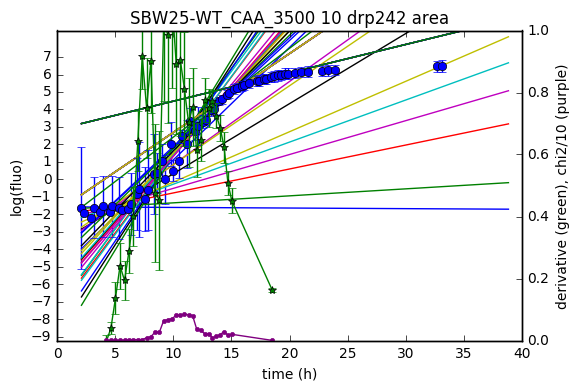

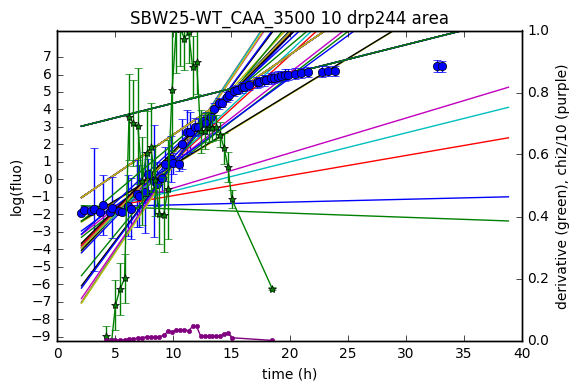

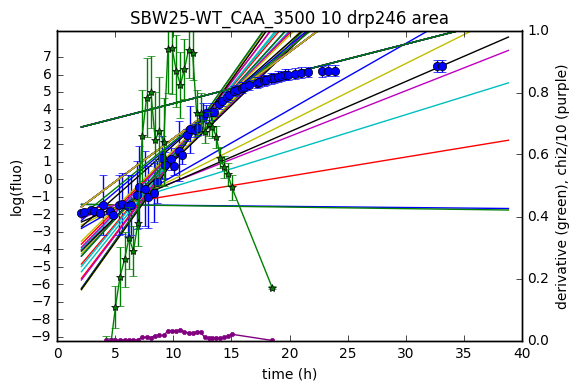

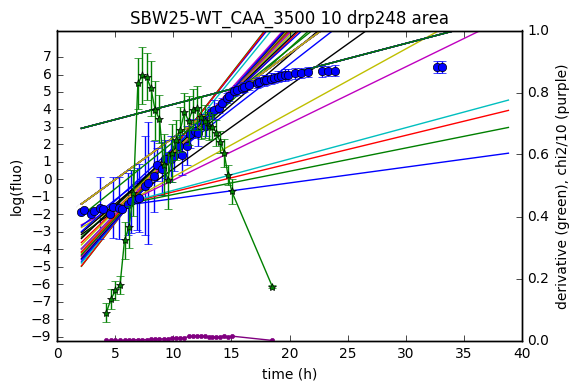

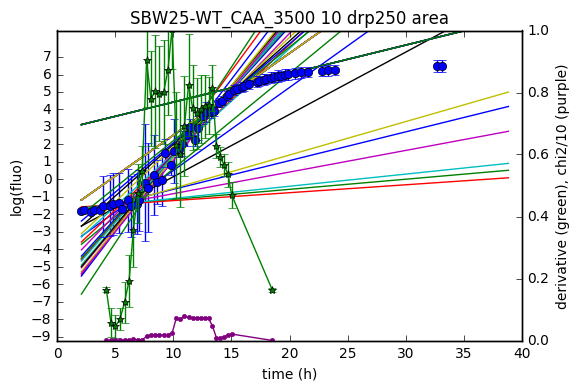

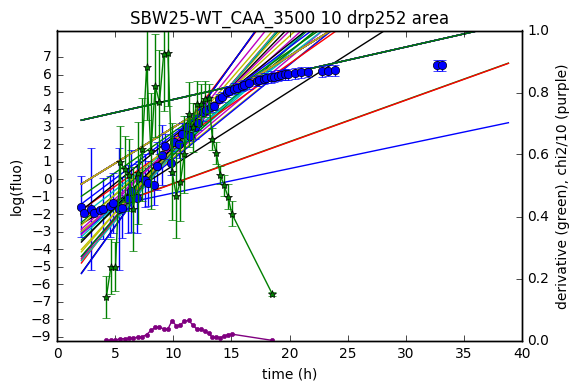

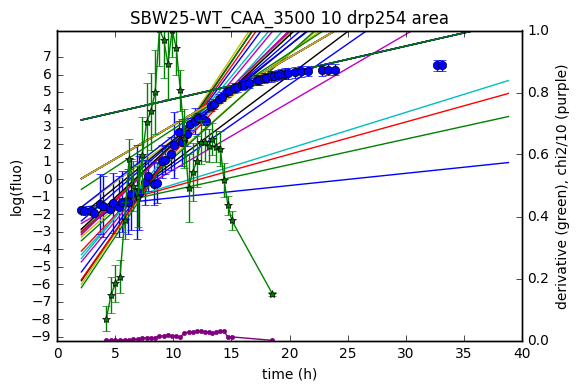

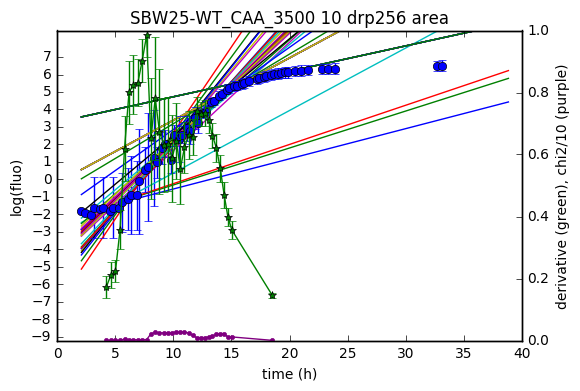

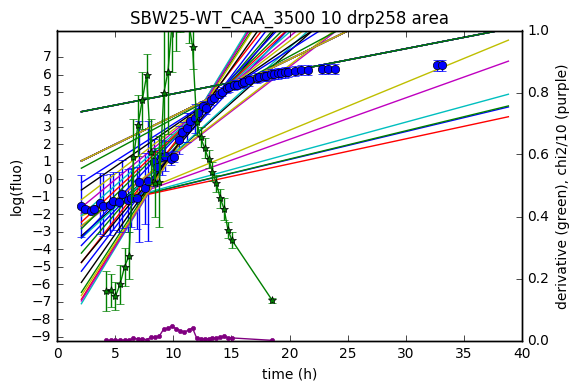

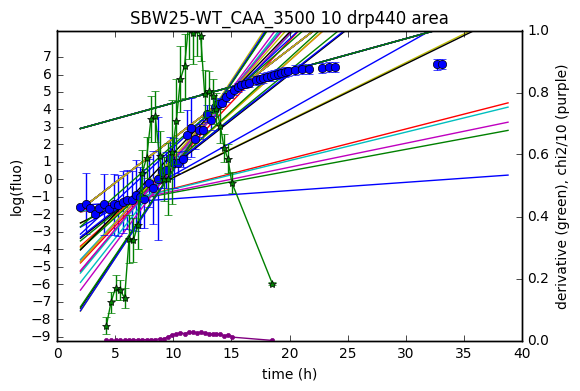

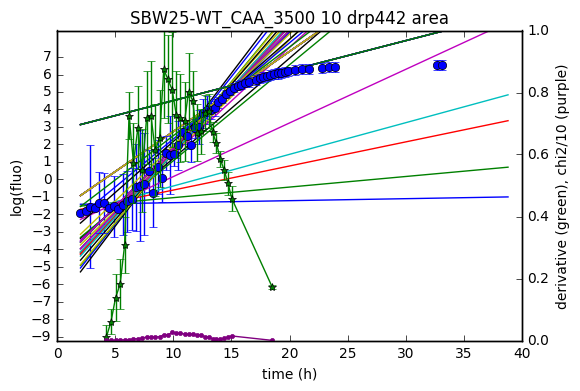

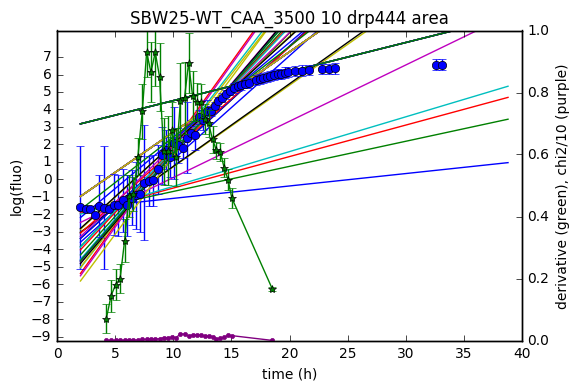

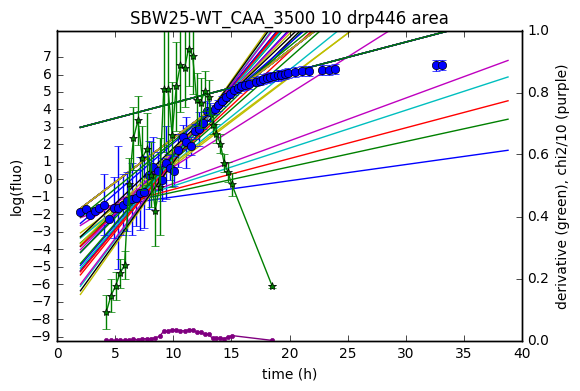

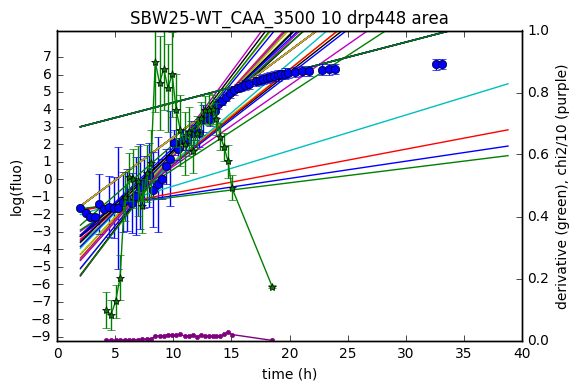

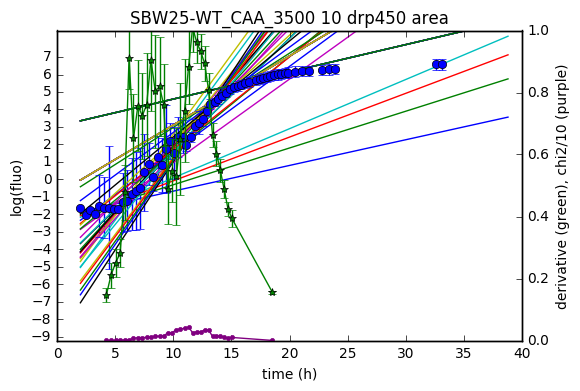

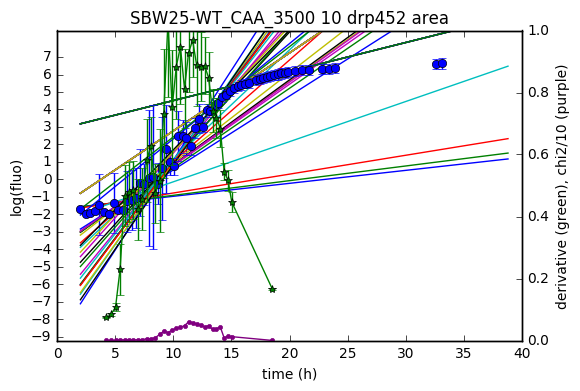

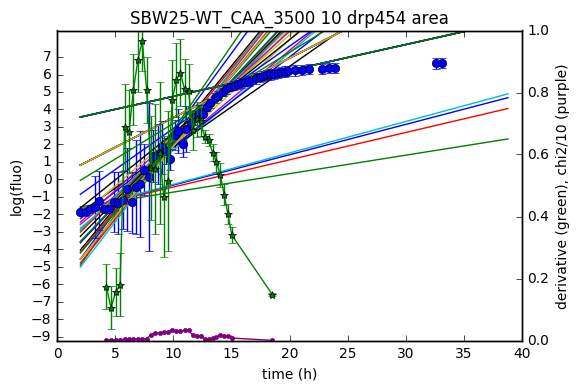

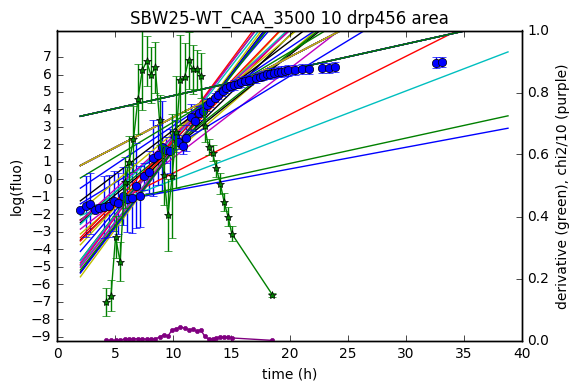

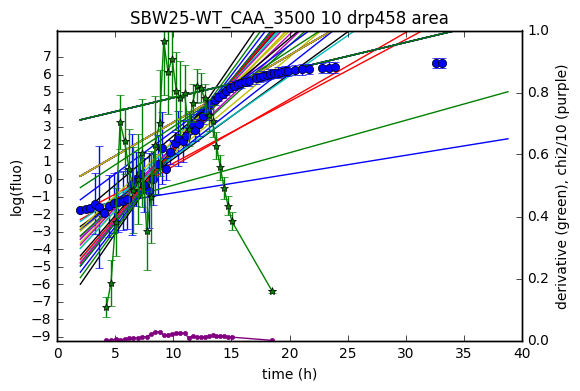

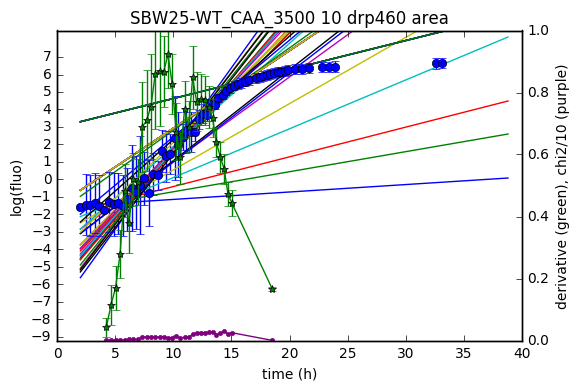

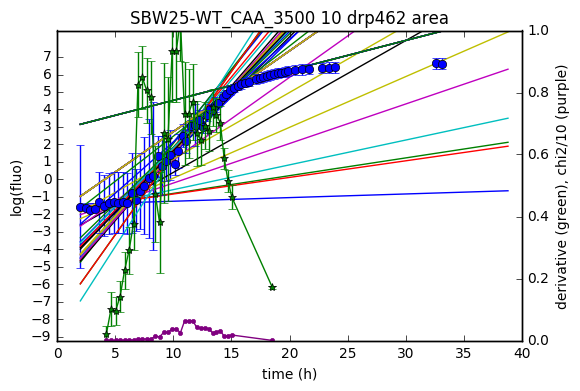

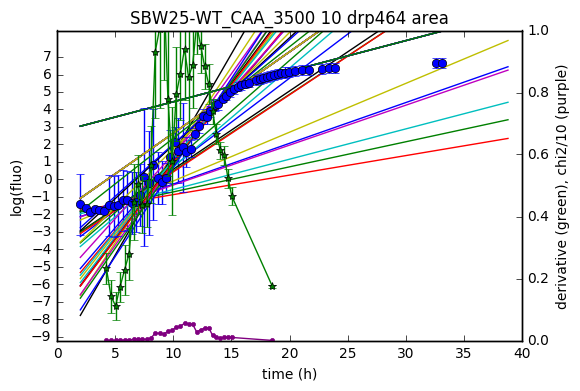

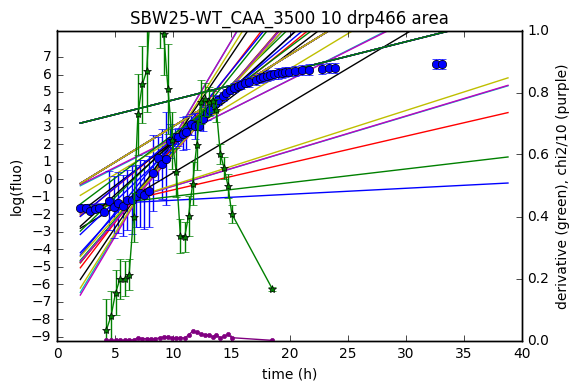

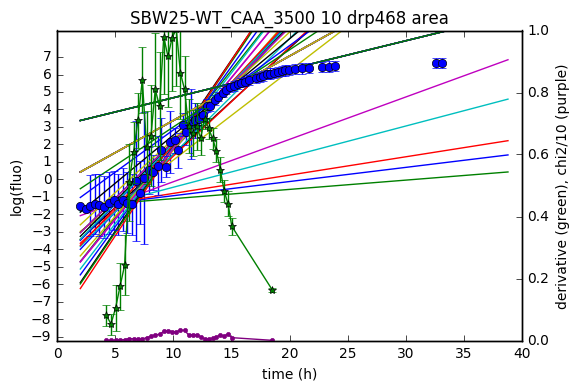

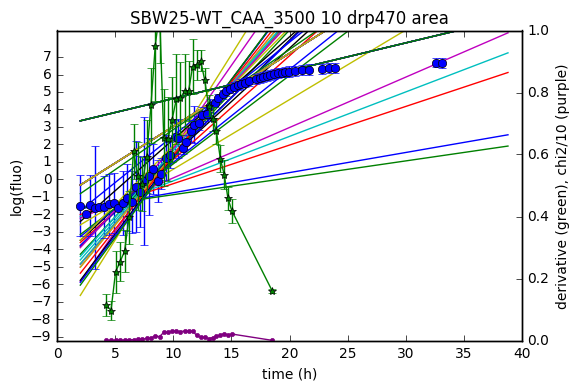

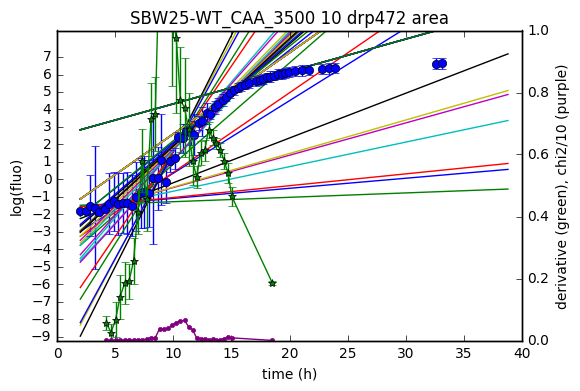

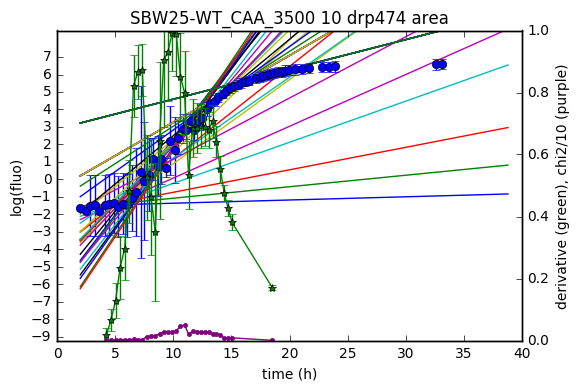

KeyboardInterrupt: 

In [127]:
#calculate the derivative and the yields
#loop over files in folder
#use the label written in the template file

#main analysis NO split
import warnings
import os

pathgrate = rootPath+'grate/'
if not os.path.exists(pathgrate):
    os.makedirs(pathgrate)

pathgrowth = rootPath+'growth/'
if not os.path.exists(pathgrowth):
    os.makedirs(pathgrowth)

    
for path in folder:#[folder[-1]]:#folder:
    [dropMap, df, label]=loadData(path)
    label=sorted(label)
    a=path.split('/')

    warnings.simplefilter('ignore', np.RankWarning)
    print('start')

    high=5000
    low=1e-4
    print(path)
    print(label)


    channel='GFP'

    print('attention area*v')
    for nbpt in range(10,15):
    #for nbpt in [5, 7, 11]:
    
    
        derData, gRate, gRateTime, incRate, chi2, lag, yld, nbDrp = plotDerivativeSeparate(df, dropMap, label,channel, low, high, pathgrowth,nbpt, .9, 1, minGrate, maxLag)
        print(len(gRate))
        #chi2.to_csv(newpath+'chi2_nbpt'+str(nbpt)+'.csv')
        gRate.to_csv(path+'gRate_nbpt'+str(nbpt)+'.csv')
        plotHistAll(gRate,label,'gRateDerivAll_nbpt'+str(nbpt)+channel,pathgrate,0.5,2,a[-3])

        nbDrp.to_csv(path+'nbDrp_nbpt'+str(nbpt)+'.csv')
        
        #incRate.to_csv(newpath+'incRate_nbpt'+str(nbpt)+'.csv')
        print(newrootpath)
        gRateTime.to_csv(path+'gRateTime_nbpt'+str(nbpt)+'.csv')
        plotHistAll(gRateTime,label,'gRateTimeAll_nbpt'+str(nbpt)+channel,pathgrate,0,5,a[-3])
        
        #plotHistAll(incRate,label,'incGRateDerivAll_nbpt'+str(nbpt)+channel,rootpath,0,.5,a[-3])
        plotHistAll(yld,label,'Yield'+channel,path,.5,2,a[-3])
        #alignDer(rootpath,derData,label,0,60,a[-3])
        plotHistAll(lag,label,'Lag'+channel,pathgrate,0,60,a[-3])
        lag.to_csv(path+'lag.csv')
        print(path)
        plotLagVsGrate(label, gRate, lag,pathgrate)

    channel='GFP'
    plotLabelSeveral(df, dropMap,label,channel, -7, 2,pathgrate+a[-3]+'ChannelGFP.jpg',a[-3],maxLag)


In [109]:
#get the dumber of the drop in the threshold percentile. threshold goes from 0 to 100%
threshold=75

for path in folder:#[folder[-2]]:
    for nbpt in range(5,16):
        print(path)
        gRate=pd.read_csv(path+ 'gRate_nbpt' + str(nbpt) + '.csv')
        nbDrp=pd.read_csv(path+ 'nbDrp_nbpt' + str(nbpt) + '.csv')
            
        idxPrctl=pddf()
        for name in gRate.columns: 
            nbDrptmp=nbDrp[name]
            prctl=np.nanpercentile(gRate[name],threshold)
            idxPrctltmp=[]
            idxPrctltmp=nbDrptmp[gRate[name]>prctl]
            idxPrctl[name]=pd.Series(idxPrctltmp.values)

        idxPrctl.to_csv(path+'nbDropPercentile_'+str(threshold)+'_nbpt'+str(nbpt)+'.csv')
print('done')


/Users/maxime/Documents/experiences/milli/expDilution_5_50_500_3500/2018-02-09_dilution_CAA_WT-stock2/analysis/
/Users/maxime/Documents/experiences/milli/expDilution_5_50_500_3500/2018-02-09_dilution_CAA_WT-stock2/analysis/
/Users/maxime/Documents/experiences/milli/expDilution_5_50_500_3500/2018-02-09_dilution_CAA_WT-stock2/analysis/
/Users/maxime/Documents/experiences/milli/expDilution_5_50_500_3500/2018-02-09_dilution_CAA_WT-stock2/analysis/
/Users/maxime/Documents/experiences/milli/expDilution_5_50_500_3500/2018-02-09_dilution_CAA_WT-stock2/analysis/
/Users/maxime/Documents/experiences/milli/expDilution_5_50_500_3500/2018-02-09_dilution_CAA_WT-stock2/analysis/
/Users/maxime/Documents/experiences/milli/expDilution_5_50_500_3500/2018-02-09_dilution_CAA_WT-stock2/analysis/
/Users/maxime/Documents/experiences/milli/expDilution_5_50_500_3500/2018-02-09_dilution_CAA_WT-stock2/analysis/
/Users/maxime/Documents/experiences/milli/expDilution_5_50_500_3500/2018-02-09_dilution_CAA_WT-stock2/an

In [15]:
for path in folder:
    for nbpt in [7,11, 13,15]:
        gRateTime=pd.read_csv(path+ 'gRateTime_nbpt' + str(nbpt) + '.csv')
        gRate=pd.read_csv(path+ 'gRate_nbpt' + str(nbpt) + '.csv')
        
        
        datagRateTime=[]
        labelListgRateTime=[]
        for experiment in gRateTime.columns:
            datagRateTime.append(gRateTime[experiment])
            labelListgRateTime.append(a[-3]+experiment)

        datagRate=[]
        labelListgRate=[]
        for experiment in gRate.columns:
            datagRate.append(gRate[experiment])
            labelListgRate.append(a[-3]+experiment)


        print(datagRate)        
        

FileNotFoundError: File b'/Users/maxime/Documents/experiences/milli/MILLIDROP_manip/2018-02-19_dilution_CAA_WT-stock2/analysis/gRateTime_nbpt7.csv' does not exist

In [21]:

def plotLagVsGrate(label, gRate, lag, rootPath):
    choice=['blue','green','red','cyan','magenta','yellow','black']
    colors=choice[0:len(label)];
    i=-1

    lagList=[]
    gRateList=[]
    stdlagList=[]
    stdgRateList=[]

    for j,tmp in enumerate(label):

        if False :
            i=i+1
            plt.scatter(np.arange(0,len(gRate[tmp])),gRate[tmp],c=colors[i])
            plt.xlabel('drop')
            plt.ylabel('gRate')
            plt.ylim([0.5,2])
            plt.xlim([-1,161])
            plt.xticks(np.arange(0,161,10))
            fig1 = plt.gcf()
            plt.grid()
            plt.show()
            print(rootPath+'grate/'+tmp)
            fig1.savefig(rootPath+'grate/'+tmp)

            fig1 = plt.gcf()
            plt.scatter(lag[tmp],gRate[tmp],c=colors[i])
            plt.xlim([0,30])
            plt.ylim([0.5,2])
            plt.xlabel('lag')
            plt.ylabel('gRate')
            plt.show()
            fig1.savefig(rootPath+'grate/lagVSgRate'+tmp)

        xxx=gRate[tmp][np.logical_not(np.isnan(gRate[tmp]))]
        xx=xxx[np.logical_not(np.isinf(xxx))]
        x=xx[np.logical_not(xx==-1)]

        gRateList.append(np.median(x))
        stdgRateList.append(np.std(x)/np.sqrt(len(x)))

        xxx=lag[tmp][np.logical_not(np.isnan(lag[tmp]))]
        xx=xxx[np.logical_not(np.isinf(xxx))]
        x=xx[np.logical_not(xx==-1)]

        lagList.append(np.median(x))    
        stdlagList.append(np.std(x)/np.sqrt(len(x)))    


    fig1 = plt.gcf()
    plt.errorbar(lagList,gRateList, xerr=stdlagList,yerr=stdgRateList, c='k', fmt='o')
    #plt.xlim([6,15])
    plt.ylim([0.5,1.2])
    plt.xlabel('lag')
    plt.ylabel('gRate')
    plt.show()
    fig1.savefig(rootPath+'lagVSgRateMedian'+tmp)

    


In [6]:
## aline the derivative peaks of the growth by peaking the position of maximum correlation in the bounds cutTimeLow,cutTimeHigh
from scipy import signal

def calculate_time_offset_from_signals(times_A, signal_A,
                                       times_B, signal_B):
    """ Calculates the time offset between signal A and signal B. """
    convoluted_signals = signal.correlate(signal_B, signal_A)
    dt_A = np.mean(np.diff(times_A))
    offset_indices = np.arange(-len(signal_A) + 1, len(signal_B))
    max_index = np.argmax(convoluted_signals)
    offset_index = offset_indices[max_index]
    time_offset = dt_A * offset_index + times_B[0] - times_A[0]
    return time_offset 


def alignDer(path,derData,label,cutTimeLow,cutTimeHigh, nameFolder):
    for lb in label:
        print(lb)
        a=derData[lb]

        ini=a.iloc[40]
        X1  = np.array(ini[0])
        Y1 = np.array(ini[1])
        
        fig1, (ax1, ax2) = plt.subplots(1,2,sharey=True)
        
        for aa in a:

            X2  = np.array(aa[0])
            Y2 = np.array(aa[1])

            cX1=X1[((cutTimeLow<X1) & (X1<cutTimeHigh))]
            cX2=X2[((cutTimeLow<X2) & (X2<cutTimeHigh))]
            cY1=Y1[((cutTimeLow<X1) & (X1<cutTimeHigh))]
            cY2=Y2[((cutTimeLow<X2) & (X2<cutTimeHigh))]

            tshift = calculate_time_offset_from_signals(cX1, cY1, cX2, cY2)
            ax1.plot(cX2-tshift,cY2,'.')
            ax2.plot(cX2,cY2,'.')
            

        ax1.set_title(lb +  'shift')
        xlim=cutTimeHigh
        ax1.set_xlim([0, xlim]) 
        ax1.set_ylim([0, 2])
        ax2.set_title(lb)
        ax2.set_xlim([0, xlim]) 
        ax2.set_ylim([0, 2]) 
        fig1.savefig(path+nameFolder+lb +  'shift')
        plt.show()

In [27]:
def plotLabelSeveral(df, dropMap, label, channel,low=0, high=5, namePath='',nameFolder='',seuiTemps=0):
    choice=['blue','green','red','cyan','magenta','yellow','black']

    colors=choice[0:len(label)];
    f, axarr = plt.subplots(len(label), sharex=True)
    
    for i,content in enumerate(dropMap[:,1]):
        for j,tmp in enumerate(label):
            if content==tmp:
                p=df[i]
                if channel=='mCherry':
                    try:
                        channelNo=2
                        axarr[j].scatter(p.time/3600, np.log(p.fluo_2_median),c=colors[j], cmap=plt.cm.RdYlGn)
                        axarr[j].plot(np.ones(2)*seuiTemps,[-10, 5],c='k')
                        axarr[j].set_ylim([low, high])
                    except Exception as inst:
                            donothing=0
                            #print(type(inst))
                        
                if channel=='GFP':
                    try:
                        channelNo=3
                        axarr[j].scatter(p.time/3600, np.log(p.fluo_3_median),c=colors[j], cmap=plt.cm.RdYlGn)
                        axarr[j].plot(np.ones(2)*seuiTemps,[-10, 5],c='k')
                        axarr[j].set_ylim([low, high])
                    except Exception as inst:
                            donothing=0
                            #print(type(inst))
                    #plt.plot(p.time/3600, np.log(p.fluo_3_median),c=colors[j])
                if channel=='PVD':
                    try:
                        channelNo=1
                        axarr[j].scatter(p.time/3600, np.log(p.fluo_1_median),c=colors[j], cmap=plt.cm.RdYlGn)
                        axarr[j].plot(np.ones(2)*seuiTemps,[-10, 5],c='k')
                        axarr[j].set_ylim([low, high])
                    except Exception as inst:
                            donothing=0
                            #print(type(inst))


    axarr[0].set_xlim([0, 48])
    axarr[0].set_xticks(np.arange(0,50,2))
    axarr[0].set_title(nameFolder+'\n'+'\n'.join(label)+'\n'+ ' '.join(choice[0:len(label)])+"\nchannel="+ str(channel)+' '+ str(channelNo) )
    axarr[-1].set_xlabel('time (h)')
    axarr[0].set_ylabel('ln(fluo) (ua)')

        
    plt.subplots_adjust(top=.6)
    plt.figure(figsize=(10,20))

    #plt.tight_layout()
    if namePath!='':

        f.savefig(namePath)
        
    plt.show()
    


#rootPath='/Users/maxime/Documents/experiences/milli/goodExperiments/'
newpath = rootPath+'growth/'

if not os.path.exists(newpath):
    os.makedirs(newpath)
    
for path in folder:
    print(newpath+a[-3]+'ChannelmC.jpg')
    a=path.split('/')

    #[dropMap, df,label] = loadData(path)
    channel='PVD'
    #plotLabelSeveral(df, dropMap, label,channel, -6, 2,path+a[-3]+'ChannelPVD.jpg')
    #plotLabelSeveral(df, dropMap, label,channel, -6, 2,newpath+a[-3]+'ChannelPVD.jpg',a[-3], seuiTemps)
    channel='GFP'
    #plotLabelSeveral(df, dropMap,label,channel, -6, 2,path+a[-3]+'ChannelGFP.jpg')
    #plotLabelSeveral(df, dropMap,label,channel, -7, 2,newpath+a[-3]+'ChannelGFP.jpg',a[-3],seuiTemps)
    channel='mCherry'
    #plotLabelSeveral(df, dropMap, label,channel, -6, 2,newpath+a[-3]+'ChannelmC.jpg',a[-3],seuiTemps)
    #plotLabelSeveral(df, dropMap, label,channel, -6, 2,path+a[-3]+'ChannelmC.jpg')


/Users/maxime/Documents/experiences/milli/expDilution_5_50_500_3500/growth/2018-02-09_dilution_CAA_WT-stock2ChannelmC.jpg
/Users/maxime/Documents/experiences/milli/expDilution_5_50_500_3500/growth/2018-02-09_dilution_CAA_WT-stock2ChannelmC.jpg
/Users/maxime/Documents/experiences/milli/expDilution_5_50_500_3500/growth/2018-02-17_dilution_CAA_WT-stock2ChannelmC.jpg
/Users/maxime/Documents/experiences/milli/expDilution_5_50_500_3500/growth/2018-02-19_dilution_CAA_WT-stock2ChannelmC.jpg


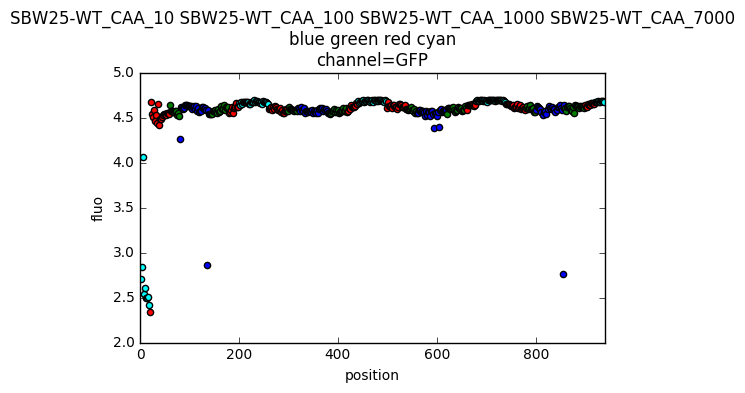

In [56]:
#plot yield as position

choice=['blue','green','red','cyan','magenta','yellow','black','blue','green','red','cyan','magenta','yellow','black']
colors=choice[0:len(label)];
channel='GFP'
#label=['CAA1mM', 'CAA100uM','CAA0M']
#label =['CAA1mM', 'CAA100uM', 'CAA0M','CAA400uM', 'CAA700uM', 'CAA0M-eth', 'CAA0M']
#label = ['CAA-1', 'CAA-5', 'CAA-10', 'CAA-25', 'CAA-50']

pos=-5
for i,content in enumerate(dropMap[:,1]):
        for j,tmp in enumerate(label):
            if content==tmp:
                p=df[i]
                if channel=='mCherry':
                    y=p.fluo_2_mean
                    plt.scatter(i, y.iloc[pos],c=colors[j], cmap=plt.cm.RdYlGn)
                if channel=='GFP':
                    y=p.fluo_3_mean
                    plt.scatter(i, y.iloc[pos],c=colors[j], cmap=plt.cm.RdYlGn)
                if channel=='PVD':
                    y=p.fluo_1_mean
                    plt.scatter(i, y.iloc[pos],c=colors[j], cmap=plt.cm.RdYlGn)

fig1 = plt.gcf()
plt.ylim([2, 5])
plt.xlim([0, 940])
plt.title(' '.join(label)+'\n'+ ' '.join(choice[0:len(label)])+"\nchannel="+ str(channel) )
plt.xlabel('position')
plt.ylabel('fluo')
plt.subplots_adjust(top=0.8)
plt.show()
fig1.savefig(path+"yieldPosition"+channel+".png")

In [9]:
print(df[1].speed)

0     2.583238
1     5.190311
2     2.553916
3     5.196305
4     2.555366
5     5.202312
6     2.562642
7     5.142857
8     2.571429
9     5.142857
10    2.453653
11    4.306220
12    2.460361
13    4.229323
14    2.456332
15    4.155125
16    2.456332
17    4.098361
18    2.450980
19    4.035874
20    2.454992
21    3.978780
22    2.459016
23    3.916449
24    2.473887
25    3.872633
26    2.477974
27    3.787879
28    2.477974
29    3.740648
30    2.483444
31    3.694581
32    2.488938
33    3.626108
34    2.491694
35    3.579952
36    2.494457
37    3.526646
38    2.500000
39    3.485670
40    2.504174
41    3.437739
42    2.509760
43    3.388554
44    2.519597
45    3.316139
46    2.516779
47    3.289474
Name: speed, dtype: float64


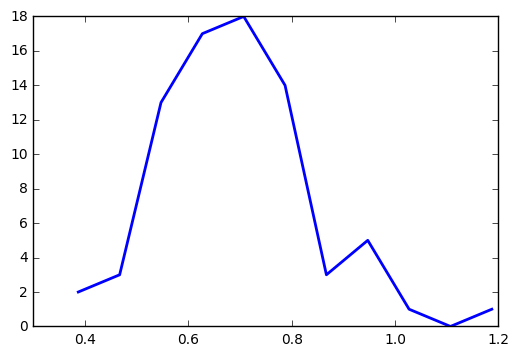

In [57]:
pathGrate='/Users/maxime/Documents/experiences/milli/goodExperiments/2017-10-17_CAABipy_pvdS/analysis/growthDerivee/'
tmp=pd.read_csv(pathGrate+'gRate_nbpt5')
#print(tmp)
data=[]
labelList=[]
for experiment in tmp.columns:
    if experiment != 'Unnamed: 0':
        data.append(tmp[experiment])
        labelList.append(a[-3]+experiment)

x=np.array(tmp['CAA1mM'])
x=x[~np.isnan(x)]

hist, bins = np.histogram(x, bins='fd')
#hist, bins = np.histogram(x, bins=100, range=(0,2))
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

plt.plot(center, hist,linewidth=2, label=' Md={:.4f}'.format(np.median(x)) +' std={:.4f}'.format(np.std(x))+' m={:.4f}'.format(np.mean(x)))
plt.show()

In [58]:
#get all the data from gRate calculated before. Append them to plot hte box plot
#rootPath='/Users/maxime/Documents/experiences/milli/expIncubation_14h-19h-43h/'
#rootPath='/Users/maxime/Documents/experiences/milli/goodExperiments/'
rootPath='/Users/maxime/Documents/experiences/milli/expIncub_4h30-6h30-24h-52h/'
#rootPath='/Users/maxime/Documents/experiences/milli/experienceDilutionWTstock2/'

folder=[join(join(rootPath,o),'analysis/') for o in listdir(rootPath) if o[:3]=='201']
data=[]
labelList=[]
param='gRate'
#param='Lag' #choose what to print
for path in folder: #[folder[0]]:
    a=path.split('/')
    pathGrate=path#+'growth/'
    if param=='gRate':
        tmp=pd.read_csv(pathGrate+'gRate_nbpt7.csv')
    if param=='Lag':
        tmp=pd.read_csv(pathGrate+'lag.csv')

    for experiment in tmp.columns:
        if experiment != 'Unnamed: 0':
            x=np.array(tmp[experiment])
            x=x[~np.isnan(x)]
            x=x[x!=-1]
            data.append(x)
            labelList.append(a[-3]+experiment)

            
# We need to draw the canvas, otherwise the labels won't be positioned and 
# won't have values yet.
pos1=[]
pos2=[]
print(labelList)
for i, l, in enumerate(labelOrder):
    for j, ll in enumerate(labelList):
        if ll==l:
            pos1.append(i) #mauvaise position
            pos2.append(j)#position actuel
        
fig, ax = plt.subplots(figsize=(20, 10))
ax.boxplot(data)
ax.set_xticklabels(labelList)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
    tick.set_fontsize(12) 
    tick.set_fontweight(10)

#plt.yticks(np.arange(0, 2, .1))
#plt.ylim([0.5,1.3])
ax.grid('on')
plt.tight_layout()

if param=='Lag':
    fig.savefig(rootPath+'MoustacheLag.png')
if param=='gRate':
    fig.savefig(rootPath+'gRateMoustache.png')
plt.show()

zpos=zip(pos1,pos2)
zgoodPos=sorted(zpos, key=lambda x: x[1])
goodPos=[list(t) for t in zip(*zgoodPos)]
goodPos=goodPos[0]

dataGood=[x for _, x in sorted(zip(goodPos,data), key=lambda pair: pair[0])]
labelGood=[x for _, x in sorted(zip(goodPos,labelList), key=lambda pair: pair[0])]

fig, ax = plt.subplots(figsize=(20, 10))
ax.boxplot(dataGood)
ax.set_xticklabels(labelGood)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
    tick.set_fontsize(12) 
    tick.set_fontweight(10)


#plt.ylim([0.5,1.3])
ax.grid('on')
plt.tight_layout()
if param=='Lag':
    fig.savefig(rootPath+'MoustacheLagOrder.png')
if param=='gRate':
    plt.yticks(np.arange(0.5, 2, .05))
    fig.savefig(rootPath+'gRateMoustacheOrder.png')
plt.show()

['2018-01-27_dilution_CAA_WT-stock24h30-6h30-24h-52hSBW25-WT_CAA_24h', '2018-01-27_dilution_CAA_WT-stock24h30-6h30-24h-52hSBW25-WT_CAA_4h30', '2018-01-27_dilution_CAA_WT-stock24h30-6h30-24h-52hSBW25-WT_CAA_52h', '2018-01-27_dilution_CAA_WT-stock24h30-6h30-24h-52hSBW25-WT_CAA_6h30', '2018-01-29_dilution_CAA_WT-stock24h30-6h30-24h-52hSBW25-WT_CAA_24h', '2018-01-29_dilution_CAA_WT-stock24h30-6h30-24h-52hSBW25-WT_CAA_4h30', '2018-01-29_dilution_CAA_WT-stock24h30-6h30-24h-52hSBW25-WT_CAA_52h', '2018-01-29_dilution_CAA_WT-stock24h30-6h30-24h-52hSBW25-WT_CAA_6h30', '2018-01-31_dilution_CAA_WT-stock24h30-6h30-24h-52hSBW25-WT_CAA_24h', '2018-01-31_dilution_CAA_WT-stock24h30-6h30-24h-52hSBW25-WT_CAA_4h30', '2018-01-31_dilution_CAA_WT-stock24h30-6h30-24h-52hSBW25-WT_CAA_52h', '2018-01-31_dilution_CAA_WT-stock24h30-6h30-24h-52hSBW25-WT_CAA_6h30', '2018-02-27_dilution_CAA_WT-stock24h30-6h30-24h-52hSBW25-WT_CAA_24h', '2018-02-27_dilution_CAA_WT-stock24h30-6h30-24h-52hSBW25-WT_CAA_4h30', '2018-02-27_

NameError: name 'labelOrder' is not defined

In [287]:

print(labelList)

['2017-11-16_dilution_CAA_WT-stock2CAA-WT-100', '2017-11-16_dilution_CAA_WT-stock2CAA-WT-1000', '2017-11-18_dilution_CAA_WT-stock2CAA-WT-100', '2017-11-18_dilution_CAA_WT-stock2CAA-WT-1000', '2017-11-18_dilution_CAA_WT-stock2CAA-WT-25', '2017-11-22_dilution_CAA_WT-stock2CAA-WT-100', '2017-11-22_dilution_CAA_WT-stock2CAA-WT-1000', '2017-11-22_dilution_CAA_WT-stock2CAA-WT-25', '2017-11-24_dilution_CAA_WT-stock2CAA-WT-100', '2017-11-24_dilution_CAA_WT-stock2CAA-WT-1000', '2017-11-24_dilution_CAA_WT-stock2CAA-WT-25']


In [151]:
labelOrder=['2018-01-17_dilution_CAA_WT-stock14h33-19h-43hSBW25GFP-14h', 
            '2018-01-19_dilution_CAA_WT-stock14h33-19h-43hSBW25GFP-14h',
            '2018-01-23_dilution_CAA_WT-stock14h33-19h-43hSBW25GFP-14h',
            '2018-01-17_dilution_CAA_WT-stock14h33-19h-43hSBW25GFP-19h',
            '2018-01-19_dilution_CAA_WT-stock14h33-19h-43hSBW25GFP-19h',
            '2018-01-23_dilution_CAA_WT-stock14h33-19h-43hSBW25GFP-19h',
            '2018-01-17_dilution_CAA_WT-stock14h33-19h-43hSBW25GFP-43h', 
            '2018-01-19_dilution_CAA_WT-stock14h33-19h-43hSBW25GFP-43h', 
            '2018-01-23_dilution_CAA_WT-stock14h33-19h-43hSBW25GFP-43h']


In [160]:
labelOrder=['2018-01-27_dilution_CAA_WT-stock24h30-6h30-24h-52hSBW25-WT_CAA_4h30',
            '2018-01-29_dilution_CAA_WT-stock24h30-6h30-24h-52hSBW25-WT_CAA_4h30',
            '2018-01-31_dilution_CAA_WT-stock24h30-6h30-24h-52hSBW25-WT_CAA_4h30',
            '2018-01-27_dilution_CAA_WT-stock24h30-6h30-24h-52hSBW25-WT_CAA_6h30',
            '2018-01-29_dilution_CAA_WT-stock24h30-6h30-24h-52hSBW25-WT_CAA_6h30',
            '2018-01-31_dilution_CAA_WT-stock24h30-6h30-24h-52hSBW25-WT_CAA_6h30',
            '2018-01-27_dilution_CAA_WT-stock24h30-6h30-24h-52hSBW25-WT_CAA_24h',
            '2018-01-31_dilution_CAA_WT-stock24h30-6h30-24h-52hSBW25-WT_CAA_24h',
            '2018-01-29_dilution_CAA_WT-stock24h30-6h30-24h-52hSBW25-WT_CAA_24h',
            '2018-01-27_dilution_CAA_WT-stock24h30-6h30-24h-52hSBW25-WT_CAA_52h',
            '2018-01-29_dilution_CAA_WT-stock24h30-6h30-24h-52hSBW25-WT_CAA_52h',
            '2018-01-31_dilution_CAA_WT-stock24h30-6h30-24h-52hSBW25-WT_CAA_52h']

In [288]:
labelOrder=['2017-11-16_dilution_CAA_WT-stock2CAA-WT-100', 
            '2017-11-18_dilution_CAA_WT-stock2CAA-WT-100',
            '2017-11-22_dilution_CAA_WT-stock2CAA-WT-100',
            '2017-11-24_dilution_CAA_WT-stock2CAA-WT-100',  
            '2017-11-18_dilution_CAA_WT-stock2CAA-WT-25',  
            '2017-11-22_dilution_CAA_WT-stock2CAA-WT-25',
            '2017-11-24_dilution_CAA_WT-stock2CAA-WT-25', 
            '2017-11-16_dilution_CAA_WT-stock2CAA-WT-1000',
            '2017-11-18_dilution_CAA_WT-stock2CAA-WT-1000',
            '2017-11-22_dilution_CAA_WT-stock2CAA-WT-1000',
            '2017-11-24_dilution_CAA_WT-stock2CAA-WT-1000']


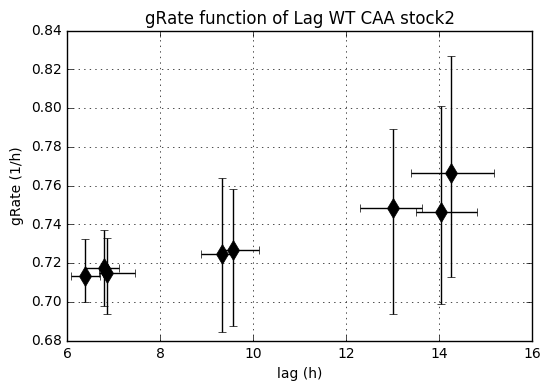

In [8]:
#get all the data from gRate calculated before. Append them to plot the box plot
#rootPath='/Users/maxime/Documents/experiences/milli/expIncubation_14h-19h-43h/'
#rootPath='/Users/maxime/Documents/experiences/milli/goodExperiments/'
#rootPath='/Users/maxime/Documents/experiences/milli/expIncub_4h30-6h30-24h-52h/'

rootPath='/Users/maxime/Documents/experiences/milli/experienceDilutionWTstock2/'
folder=[join(join(rootPath,o),'analysis/') for o in listdir(rootPath) if isdir(join(rootPath,o))]

choice=['o','*','d','x','s','^','p']
i=-1
labelList=[]   
labelListLag=[]


def substract(a,b):
    res=[a_i - b_i for a_i, b_i in zip(a, b)]
    return res
    
for path in folder[:-2]: #[folder[0]]:
    a=path.split('/')
    pathGrate=path+'growth/'
    tmp=pd.read_csv(pathGrate+'gRate_nbpt7.csv')
    tmpLag=pd.read_csv(path+'lag.csv')
    i=i+1

    data=[]
    data10=[]
    data90=[]
    datastd=[]
    dataLag=[]
    data10Lag=[]
    data90Lag=[]

    for experiment in tmp.columns:
        if experiment != 'Unnamed: 0':
            x=np.array(tmp[experiment])
            x=x[~np.isnan(x)]
            x=x[x!=-1]
            data.append(np.median(x))
            data10.append(np.percentile(x,25))
            data90.append(np.percentile(x,75))
            datastd.append(np.std(x)/np.sqrt(len(x)))
            labelList.append(a[-3]+experiment)
    
    for experiment in tmpLag.columns:
        if experiment != 'Unnamed: 0':
            x=np.array(tmpLag[experiment])
            x=x[~np.isnan(x)]
            x=x[x!=-1]
            dataLag.append(np.median(x))
            data10Lag.append(np.percentile(x,25))
            data90Lag.append(np.percentile(x,75))
            labelListLag.append(a[-3]+experiment)
            
    plt.errorbar(dataLag,data,xerr=[substract(dataLag,data10Lag), substract(data90Lag,dataLag)],yerr=[substract(data,data10), substract(data90,data)], c='k', fmt=choice[i],markersize=10)
    
plt.title('gRate function of Lag WT CAA stock2')
plt.grid('on')
plt.xlabel('lag (h)')
plt.ylabel('gRate (1/h)')
fig1 = plt.gcf()
fig1.savefig(rootPath+'gRateVSlag')
plt.show()



['/Users/maxime/Documents/experiences/milli/experienceDilutionWTstock2/2017-11-16_dilution_CAA_WT-stock2/analysis/', '/Users/maxime/Documents/experiences/milli/experienceDilutionWTstock2/2017-11-18_dilution_CAA_WT-stock2/analysis/', '/Users/maxime/Documents/experiences/milli/experienceDilutionWTstock2/2017-11-22_dilution_CAA_WT-stock2/analysis/', '/Users/maxime/Documents/experiences/milli/experienceDilutionWTstock2/2017-11-24_dilution_CAA_WT-stock2/analysis/']
CAA-WT-100
CAA-WT-1000
CAA-WT-100
CAA-WT-1000
CAA-WT-25
CAA-WT-100
CAA-WT-1000
CAA-WT-25
CAA-WT-100
CAA-WT-1000
CAA-WT-25
['2017-11-16_dilution_CAA_WT-stock2CAA-WT-100', '2017-11-16_dilution_CAA_WT-stock2CAA-WT-1000', '2017-11-18_dilution_CAA_WT-stock2CAA-WT-100', '2017-11-18_dilution_CAA_WT-stock2CAA-WT-1000', '2017-11-18_dilution_CAA_WT-stock2CAA-WT-25', '2017-11-22_dilution_CAA_WT-stock2CAA-WT-100', '2017-11-22_dilution_CAA_WT-stock2CAA-WT-1000', '2017-11-22_dilution_CAA_WT-stock2CAA-WT-25', '2017-11-24_dilution_CAA_WT-stock2C

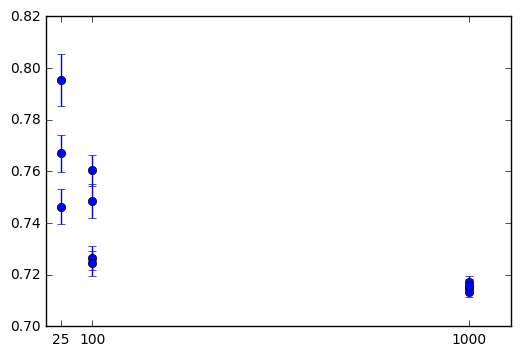

In [25]:

rootPath='/Users/maxime/Documents/experiences/milli/experienceDilutionWTstock2/'
folder=[join(join(rootPath,o),'analysis/') for o in listdir(rootPath) if o[:3]=='201']

choice=['o','*','d','x','s','^','p']
i=-1
labelList=[]   
labelListLag=[]

data=[]
data10=[]
data90=[]
datastd=[]
dataLag=[]
data10Lag=[]
data90Lag=[]

print(folder)

for path in folder: #[folder[0]]:
    a=path.split('/')
    pathGrate=path
    tmp=pd.read_csv(pathGrate+'gRate_nbpt7.csv')
    tmpLag=pd.read_csv(path+'lag.csv')
    i=i+1


    for experiment in tmp.columns:
        if experiment != 'Unnamed: 0':
            print(experiment)
            x=np.array(tmp[experiment])
            x=x[~np.isnan(x)]
            x=x[x!=-1]
            data.append(np.median(x))
            data10.append(np.percentile(x,25))
            data90.append(np.percentile(x,75))
            datastd.append(np.std(x)/np.sqrt(len(x)))
            labelList.append(a[-3]+experiment)

print(labelList)
plt.errorbar([100,1000,100,1000,25,100,1000,25,100,1000,25],data,yerr=datastd,fmt='o')
plt.xlim([-10,1100])
plt.xticks([25,100,1000])
plt.show()